In [14]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Initializing objects:**

In [17]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  365
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
alpha_sirio = 101.28  # right ascension
delta_sirio = -16.7161  # declination
sirio = Source("sirio", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6)
sirio2 = Source("sirio2", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6) #98, -15, 350, -500, -1000, -13.9)
print('Source created')
scanSirio = Scanner() 
print('Scanner created')
sirio.reset()
print([sirio.alpha, sirio.delta, sirio.parallax, sirio.mu_alpha_dx, sirio.mu_delta])

Sat created
Source created
Scanner created
[1.767669466419857, -0.29175098309262415, 1.8384619601354712e-06, -6.9464484158848486e-09, -1.6246438518145694e-08]


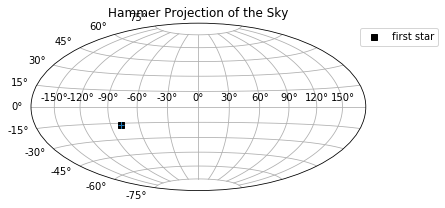

In [3]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []

for i, s in enumerate([sirio, sirio2]):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')
        pass


plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

# **Scan**

In [4]:
1/24*3

0.125

In [18]:
scanSirio.start(gaia, sirio, ti=t_init, tf=t_end)
print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)

Starting wide_scan with time from 0 to 365 days
      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 9.586563909073732
      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 41.55002559983841
      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 89.43814050895162
      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 100.68603093351706
      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 149.55670111235565
      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 174.78619267030336
      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 214.9716169022323
      converged: True
           flag: 'converged'
 function_calls: 6
     iterat

In [6]:
scanSirio.optimize_roots

[9.586563909073732,
 41.55002559983841,
 89.43814050895162,
 100.68603093351706,
 149.55670111235565,
 174.78619267030336,
 214.9716169022323,
 267.40321154547445,
 267.6532162165947,
 293.8983901208061,
 294.1483973638092,
 352.5781383953659]

In [7]:
angle = np.radians(270)
angle % (2*np.pi)

4.71238898038469

# **Plots:**

In [9]:
sat = gaia
source = sirio
satellite = gaia 
scan = scanSirio


In [10]:


def vector_error(t):
                u_lmn_unit = source.unit_topocentric_function(sat, t)
                vector_error_lmn = u_lmn_unit - sat.func_x_axis_lmn(t)  # Error vector
                vector_error_xyz = ft.lmn_to_xyz(sat.func_attitude(t), vector_error_lmn)
                return vector_error_xyz



In [11]:
phi_objective(1)
z_condition(1)

-0.12742565366836145

In [12]:
for t in scanSirio.obs_times:
    print(vector_error(t))

[-1.11334683e-06 -5.65384328e-15 -1.49221058e-03]
[-3.70305037e-06  1.89284894e-13 -2.72141269e-03]
[-3.55198097e-06 -8.41964646e-14 -2.66532349e-03]
[-3.27571332e-06  2.64019492e-14  2.55957338e-03]
[-6.48540167e-06 -3.17122630e-14 -3.60149431e-03]
[-1.60730912e-06  1.18010609e-13 -1.79293493e-03]
[-2.28427845e-06 -1.20741795e-13 -2.13741706e-03]
[-5.99945520e-07  2.66437263e-15 -1.09539522e-03]
[-7.32321824e-06 -3.62948387e-13  3.82705929e-03]
[-5.62615303e-07 -1.34411416e-13  1.06076873e-03]
[-4.12691841e-06 -3.21981482e-14 -2.87294619e-03]
[-1.67372991e-06 -2.38928140e-13 -1.82960570e-03]


<IPython.core.display.Javascript object>


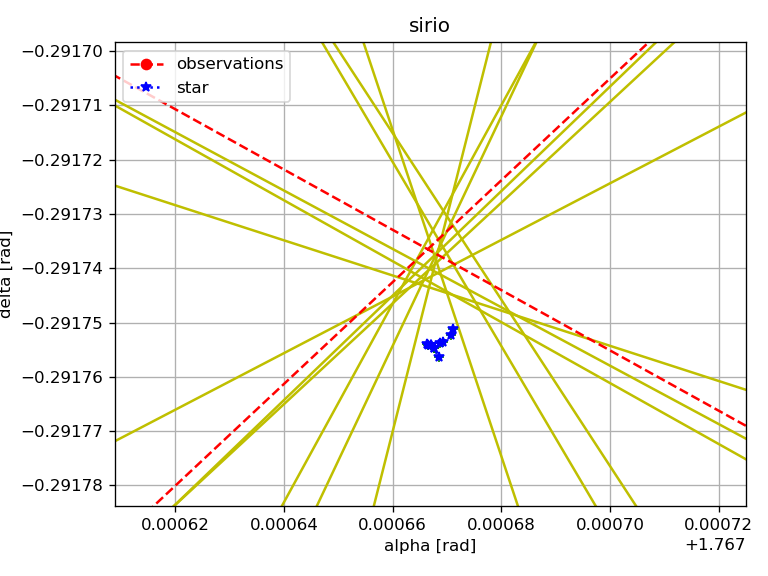

In [20]:


alphas_obs, deltas_obs, radius_obs = ([], [], [])
star_alphas, star_deltas, star_radius = ([], [], [])
z_alphas, z_deltas = ([], [])
green_alphas, green_deltas = ([], [])

plt.figure()
# for each of the observed times we plot the position of the x-axis in lmn
# of the scanner
for i, t in enumerate(scan.obs_times):

    alpha, delta, radius = ft.vector_to_polar(satellite.func_x_axis_lmn(t))
    alphas_obs.append(alpha % (2 * np.pi))
    deltas_obs.append(delta)
    # radius_obs.append(radius)
    # source.set_time(t)
    # star_alphas.append(source.alpha)
    # star_deltas.append(source.delta)
    alpha2, delta2, _, _ = source.topocentric_angles(satellite, t)
    star_alphas.append(alpha2)
    star_deltas.append(delta2)
    # star_deltas.append(source.radius)

    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    
    v_error = vector_error(t)

    vectorz1 = xaxis + np.radians(0.5) * zaxis
    vectorz2 = xaxis - np.radians(0.5) * zaxis

    z_alpha_1, z_delta_1, _ = ft.vector_to_polar(vectorz1)
    z_alpha_2, z_delta_2, _ = ft.vector_to_polar(vectorz2)

    z_alphas.append([z_alpha_1, z_alpha_2])
    z_deltas.append([z_delta_1, z_delta_2])
    
    vectorz1 = xaxis + v_error[2]*zaxis

    green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
    green_alphas.append(green_alpha)
    green_deltas.append(green_delta)

# For each couple of ([alpha1,alpha2],[delta1,delta2])
for alpha_delta in zip(z_alphas, z_deltas):
    plt.plot(alpha_delta[0], alpha_delta[1], 'yo-')
    
plt.plot(green_alphas, green_deltas, 'g+:')

plt.plot(alphas_obs, deltas_obs, 'ro--', label='observations')  # plot observation as re dots
plt.plot(star_alphas, star_deltas, 'b*:', label='star')  # plot stars as blu stars

# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.legend(loc='upper left'), plt.title('%s' % source.name)
plt.xlabel('alpha [rad]'), plt.ylabel('delta [rad]')
plt.axis('equal'), plt.tight_layout()
plt.margins(0.1), plt.grid()
plt.show()

In [ ]:
optimize.brentq(f=eta_error, a=t, b=t+time_step, args=(